<h1>Capstone 1: Machine Learning Algorithms, Baseline</h1>

<a id='TOC'></a>
<strong>Table of Contents</strong>
<ol>
    <li>Preliminaries</li>
    <ol>
        <li><a href=#Sec01A>Import EMS Incident Data</a></li>
        <li><a href=#Sec01B>Preprocess Dataset</a></li>
        <li><a href=#Sec01C>Segment Variables</a></li>
    </ol>
    <li>Variable Encoding Methods</li>
    <ol>
        <li><a href=#Sec02A>Inspect Target Variable</a></li>
        <li><a href=#Sec02B>One-Hot Encoding</a></li>
        <li><a href=#Sec02C>Binary Encoding</a></li>
    </ol>
    <li>Baseline Models</li>
    <ol>
        <li><a href=#Sec03A>Create Train and Test Sets</a></li>
        <li><a href=#Sec03B>Logistic Regression</a></li>
        <li><a href=#Sec03C>Random Forest</a></li>
        <li><a href=#Sec03D>Analysis of Model Performance</a></li>
    </ol>
</ol>

<p>The goal of this project is to develop machine learning models that predict whether or not the outcome of an EMS incident will result in a fatality. This is a supervised, binary classification problem. Analyses will be performed on a collection of nearly 8 million records of documented incidents, which span the six year period from January 2013 through December 2018, and appropriate predictive models will be developed to achieve the primary objective. This dataset is robust and contains several feature variables, of mixed data types, that describe both various attributes of each incident as well as the responsive action taken by the FDNY. All of the aforementioned factors affect an individual’s survivability once a response is initiated.</p>

<p>The dataset will be preprocessed using insights gained through prior analyses and various encoding methods for categorical variables. Afterwards, baseline classifiers will be constructed and assessed for their model performance on both training and test data.</p>

<h2 style="text-transform: uppercase;">1. Preliminaries</h2>

<a id='Sec01A'></a>
<h4>1A: Import EMS Incident Data</h4>

In [1]:
# Import packages and modules
import pandas as pd
import numpy as np
import category_encoders as ce
import time

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             classification_report, plot_confusion_matrix)

# Prospective classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Assign file path
input_path_ems = '../data/clean_EMS_data.csv'

# Read CSV data into a Pandas DataFrame
datetime_cols = ['incident_datetime',
                 'first_assignment_datetime',
                 'first_activation_datetime',
                 'first_on_scene_datetime',
                 'first_to_hosp_datetime',
                 'first_hosp_arrival_datetime',
                 'incident_close_datetime']

df = pd.read_csv(input_path_ems,compression='gzip',
                 parse_dates=datetime_cols,
                 index_col=['incident_datetime'])

In [3]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8054500 entries, 2018-12-31 23:59:46 to 2013-01-09 09:05:12
Data columns (total 29 columns):
year                           int64
month                          int64
day                            int64
hour                           int64
weekday                        int64
borough                        object
zipcode                        float64
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 object
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         object
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    int6

<p><a href=#TOC>TOC</a></p>

<a id="Sec01B"></a>
<h4>1B: Preprocess Dataset</h4>

In [4]:
# Change dtypes
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')

<p>Both exploratory data analysis and inferential statistics performed in prior notebooks (<a href="https://github.com/jdwill917/SB-DSCT-Repo/blob/master/Capstones/Capstone%201/code/CP1-02_EDA.ipynb" target="_blank">CP1-02_EDA</a> and <a href="https://github.com/jdwill917/SB-DSCT-Repo/blob/master/Capstones/Capstone%201/code/CP1-03_Stats.ipynb" target="_blank">CP1-03_Stats</a>, respectively) revealed there are multiple redundant or immaterial variables within the dataset. Therefore, they will be removed from the dataset.</p>

In [5]:
# Remove immaterial columns
list_of_cols = ['latitude','longitude',
                'aland_sqmi','awater_sqmi','held_indicator',
                'initial_call_type','initial_severity_level',
                'first_assignment_datetime','incident_dispatch_area',
                'dispatch_time','travel_time',
                'first_activation_datetime','first_on_scene_datetime',
                'first_to_hosp_datetime','first_hosp_arrival_datetime',
                'incident_close_datetime','incident_disposition_code']
df.drop(list_of_cols,axis=1,inplace=True)

In [6]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8054500 entries, 2018-12-31 23:59:46 to 2013-01-09 09:05:12
Data columns (total 12 columns):
year                    int64
month                   int64
day                     int64
hour                    int64
weekday                 int64
borough                 category
zipcode                 category
final_call_type         object
final_severity_level    int64
response_time           int64
life_threatening        bool
fatality                bool
dtypes: bool(2), category(2), int64(7), object(1)
memory usage: 1005.7 MB


In [7]:
df.head()

,year,month,day,hour,weekday,borough,zipcode,final_call_type,final_severity_level,response_time,life_threatening,fatality
incident_datetime,,,,,,,,,,,,
2018-12-31 23:59:46,2018,12,31,23,1,BROOKLYN,11201.0,CARDBR,2,461,True,False
2018-12-31 23:49:42,2018,12,31,23,1,BROOKLYN,11201.0,UNC,2,328,True,False
2018-12-31 23:24:58,2018,12,31,23,1,BROOKLYN,11201.0,SICK,6,425,False,False
2018-12-31 23:04:54,2018,12,31,23,1,BROOKLYN,11201.0,SICK,6,679,False,False
2018-12-31 22:08:50,2018,12,31,22,1,BROOKLYN,11201.0,SEIZR,3,455,True,False


<p>The clean dataset is now comprised of eleven feature variables that will be used in the development of ML algorithms. <a href=#TOC>TOC</a></p>

<a id="Sec01C"></a>
<h4>1C: Segment Feature Variables</h4>

In [8]:
# Numeric feature variables
var_names_num = ['year','month','day','hour','weekday','response_time']
vars_num = df[var_names_num]

# Ordinal feature variables
var_names_ord = ['final_severity_level','life_threatening']
vars_ord = df[var_names_ord]

# Nominal feature variables
var_names_nom = ['borough','zipcode','final_call_type']
vars_nom = df[var_names_nom]

In [9]:
# Print count of labels for each ordinal feature variable
print('COUNT OF ORDINAL FEATURE LABELS')
print()
for col in vars_ord.columns:
    print(f'{col:21}: {len(vars_ord[col].unique())} labels')
print()

# Print count of labels for each nominal feature variable
print('COUNT OF NOMINAL FEATURE LABELS')
print()
for col in vars_nom.columns:
    print(f'{col:16}: {len(vars_nom[col].unique()):3} labels')

COUNT OF ORDINAL FEATURE LABELS

final_severity_level : 8 labels
life_threatening     : 2 labels

COUNT OF NOMINAL FEATURE LABELS

borough         :   6 labels
zipcode         : 208 labels
final_call_type : 135 labels


Few machine learning algorithms perform well with categorical variables. Thus, such values will have to be encoded as numeric types. Two of the five categorical feature variables (`zipcode` and `final_call_type`) have a high cardinality as indicated above. In the next section, different encoding methods will be applied to the dataset and tested with different baseline models. <p><a href=#TOC>TOC</a></p>

<hr>

<h2 style="text-transform: uppercase;">2. Variable Encoding Methods</h2>

<a id="Sec02A"></a>
<h4>2A: Inspect Target Variable</h4>

In [10]:
df['fatality'].value_counts()

False    7715190
True      339310
Name: fatality, dtype: int64

In [11]:
df['fatality'].value_counts(normalize=True)

False    0.957873
True     0.042127
Name: fatality, dtype: float64

The target variable is segmented into two classes: <strong>fatalities</strong> (`fatality == True`) and <strong>survivals</strong> (`fatality == False`). Based on the frequency values provided above, it is clear that <strong>fatalities</strong> represent the <em>minority</em> class whereas <strong>survivals</strong> represent the <em>majority</em> class. Whether or not this will have an impact on the effectiveness of baseline model has yet to be determined. <p><a href=#TOC>TOC</a></p>

<a id="Sec02B"></a>
<h4>2B: One-Hot Encoding</h4>

In [12]:
# One-Hot encode dataframe
df_ohe = pd.get_dummies(df,prefix=['brgh','zip','fct'])

# Inspect encoded dataframe
print(df_ohe.shape)
df_ohe.head()

(8054500, 358)


,year,month,day,hour,weekday,final_severity_level,response_time,life_threatening,fatality,brgh_BRONX,...,fct_STAB,fct_STATEP,fct_STATFC,fct_TRAUMA,fct_UNC,fct_UNCFC,fct_UNCFT,fct_UNCRF,fct_UNKNOW,fct_VENOM
incident_datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:59:46,2018,12,31,23,1,2,461,True,False,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 23:49:42,2018,12,31,23,1,2,328,True,False,0,...,0,0,0,0,1,0,0,0,0,0
2018-12-31 23:24:58,2018,12,31,23,1,6,425,False,False,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 23:04:54,2018,12,31,23,1,6,679,False,False,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 22:08:50,2018,12,31,22,1,3,455,True,False,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Target variable
y_ohe = df_ohe['fatality'].values
print(f'y\nType: {type(y_ohe)}\nShape: {y_ohe.shape}')
print()

# All feature variables
X_tmp = df_ohe.drop(columns=['fatality'])
X_ohe = X_tmp.values
print(f'X (One-Hot Encoding)\nType: {type(X_ohe)}\nShape: {X_ohe.shape}')

y
Type: <class 'numpy.ndarray'>
Shape: (8054500,)

X (One-Hot Encoding)
Type: <class 'numpy.ndarray'>
Shape: (8054500, 357)


<p>Applying One-Hot encoding increases the number of feature variables in the clean dataset from 11 to 357. <a href=#TOC>TOC</a></p>

<a id="Sec02C"></a>
<h4>2C: Binary Encoding</h4>

In [14]:
# Binary encode dataframe
enc_binary = ce.BinaryEncoder(cols=var_names_nom)
df_bin = enc_binary.fit_transform(df)

# Inspect encoded dataframe
print(df_bin.shape)
df_bin.head()

(8054500, 31)


,year,month,day,hour,weekday,borough_0,borough_1,borough_2,borough_3,zipcode_0,...,final_call_type_3,final_call_type_4,final_call_type_5,final_call_type_6,final_call_type_7,final_call_type_8,final_severity_level,response_time,life_threatening,fatality
incident_datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:59:46,2018,12,31,23,1,0,0,1,0,0,...,0,0,0,0,0,1,2,461,True,False
2018-12-31 23:49:42,2018,12,31,23,1,0,0,1,0,0,...,0,0,0,0,1,0,2,328,True,False
2018-12-31 23:24:58,2018,12,31,23,1,0,0,1,0,0,...,0,0,0,0,1,1,6,425,False,False
2018-12-31 23:04:54,2018,12,31,23,1,0,0,1,0,0,...,0,0,0,0,1,1,6,679,False,False
2018-12-31 22:08:50,2018,12,31,22,1,0,0,1,0,0,...,0,0,0,1,0,0,3,455,True,False


In [15]:
# Target variable
y_bin = df_bin['fatality'].values
print(f'y\nType: {type(y_bin)}\nShape: {y_bin.shape}')
print()

# All feature variables
X_bin = df_bin.iloc[:,:-1].values
print(f'X (Binary Encoding)\nType: {type(X_bin)}\nShape: {X_bin.shape}')

y
Type: <class 'numpy.ndarray'>
Shape: (8054500,)

X (Binary Encoding)
Type: <class 'numpy.ndarray'>
Shape: (8054500, 30)


<p>Applying binary encoding increases the number of feature variables in the clean dataset from 11 to 30. <a href=#TOC>TOC</a></p>

<hr>

<h2 style="text-transform: uppercase;">3. Baseline Models</h2>

<a id="Sec03A"></a>
<h4>3A: Create Train and Test Sets</h4>

In [16]:
# Initialize parameters
RANDOM_STATE = 917
TEST_SIZE = 0.20

In [17]:
# # Split the One-Hot encoded data into a training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_ohe, 
#                                                     test_size=TEST_SIZE, 
#                                                     random_state=RANDOM_STATE)

In [18]:
# Split the binary encoded data into a training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [19]:
# Define function to calculate target class counts
def get_class_counts(arr):
    class_f = sum(arr)
    class_s = len(arr) - class_f
    return {'Fatalities': class_f, 'Survivals':class_s}

# Define function to calculate target class proportions
def get_class_proportions(arr):
    class_f = round(sum(arr)/len(arr),4)
    class_s = 1 - class_f
    return {'Fatalities': class_f, 'Survivals':class_s}

# Output results
print(f'TRAINING DATA = {len(y_train)} observations')
print(f'Class Counts: {get_class_counts(y_train)}')
print(f'Proportions:  {get_class_proportions(y_train)}')
print()
print(f'TEST DATA     = {len(y_test)} observations')
print(f'Class Counts: {get_class_counts(y_test)}')
print(f'Proportions:  {get_class_proportions(y_test)}')

TRAINING DATA = 6443600 observations
Class Counts: {'Fatalities': 271223, 'Survivals': 6172377}
Proportions:  {'Fatalities': 0.0421, 'Survivals': 0.9579}

TEST DATA     = 1610900 observations
Class Counts: {'Fatalities': 68087, 'Survivals': 1542813}
Proportions:  {'Fatalities': 0.0423, 'Survivals': 0.9577}


<p><a href=#TOC>TOC</a></p>

<a id="Sec03B"></a>
<h4>3B: Logistic Regression</h4>

In [20]:
# Instantiate a baseline Logistic Regression classifier
clf_lr = LogisticRegression(random_state=RANDOM_STATE,max_iter=10000)

# Fit the model to the binary encoded dataset
start_time = time.time()
clf_lr.fit(X_train,y_train)
print(f'Runtime: {time.time()-start_time:.4f} seconds')

Runtime: 691.6292 seconds


<p><a href=#TOC>TOC</a></p>

<a id="Sec03C"></a>
<h4>3C: Random Forest</h4>

In [21]:
# Instantiate a baseline Random Forest classifier
clf_rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Fit the model to the binary encoded dataset
start_time = time.time()
clf_rf.fit(X_train,y_train)
print(f'Runtime: {time.time()-start_time:.4f} seconds')

Runtime: 4984.7448 seconds


<p><a href=#TOC>TOC</a></p>

<a id="Sec03D"></a>
<h4>3D: Analysis of Model Performance</h4>

<p>Due to the context of the business problem, the main metric that will be used to evaluate the classifiers in this analysis is <strong>recall (sensitivity)</strong>. Given that the positive class represents a fatality, it is imperative to predict such an occurence as often as possible <em>when it actually occurs</em>; this is the true positive rate by definition. Ideally, this rate should be as close as possible to 1. Thus, recall score is the most appropriate metric for model performance.</p>

<p>A secondary metric that is also useful for this particular problem is <strong>precision</strong>. In this context, the precision measures how often the model is correct <em>when it predicts</em> that a fatality occurred. Unlike the recall score, there is more flexibility with the range of the precision score since it is acceptable to predict some instances as fatalities when they actually are not (false positives).</p>

<p>The aforementioned information can be easily obtained via a clasification report and a confusion matrix.</p>

In [22]:
# Define null accuracy
def null_accuracy(y):
    return max(y.mean(),1-y.mean()) # percentage of the most frequent class in y

In [23]:
# Make predictions with Logistic Regression classifier
ypred_train_lr = clf_lr.predict(X_train)
ypred_test_lr = clf_lr.predict(X_test)

# Evaluation metrics for Logistic Regression classifier
print('CLASSIFIER: LOGISTIC REGRESSION (TRAINING DATA)')
print()
print(f'Classification Accuracy: {accuracy_score(y_train, ypred_train_lr):.4f} (y_train, ypred_train_lr)')
print(f'Null Accuracy:           {null_accuracy(y_train):.4f} (y_train)')
print(f'Recall Score:            {recall_score(y_train, ypred_train_lr):.4f} (y_train, ypred_train_lr)')
print()
print('Classification Report:')
print(classification_report(y_train, ypred_train_lr))
print()
print()
print('CLASSIFIER: LOGISTIC REGRESSION (TEST DATA)')
print()
print(f'Classification Accuracy: {accuracy_score(y_test, ypred_test_lr):.4f} (y_test, ypred_test_lr)')
print(f'Null Accuracy:           {null_accuracy(y_test):.4f} (y_test)')
print(f'Recall Score:            {recall_score(y_test, ypred_test_lr):.4f} (y_test, ypred_test_lr)')
print()
print('Classification Report:')
print(classification_report(y_test, ypred_test_lr))

CLASSIFIER: LOGISTIC REGRESSION (TRAINING DATA)

Classification Accuracy: 0.9578 (y_train, ypred_train_lr)
Null Accuracy:           0.9579 (y_train)
Recall Score:            0.0018 (y_train, ypred_train_lr)

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98   6172377
        True       0.26      0.00      0.00    271223

    accuracy                           0.96   6443600
   macro avg       0.61      0.50      0.49   6443600
weighted avg       0.93      0.96      0.94   6443600



CLASSIFIER: LOGISTIC REGRESSION (TEST DATA)

Classification Accuracy: 0.9576 (y_test, ypred_test_lr)
Null Accuracy:           0.9577 (y_test)
Recall Score:            0.0018 (y_test, ypred_test_lr)

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98   1542813
        True       0.28      0.00      0.00     68087

    accuracy                           0.96   1610900


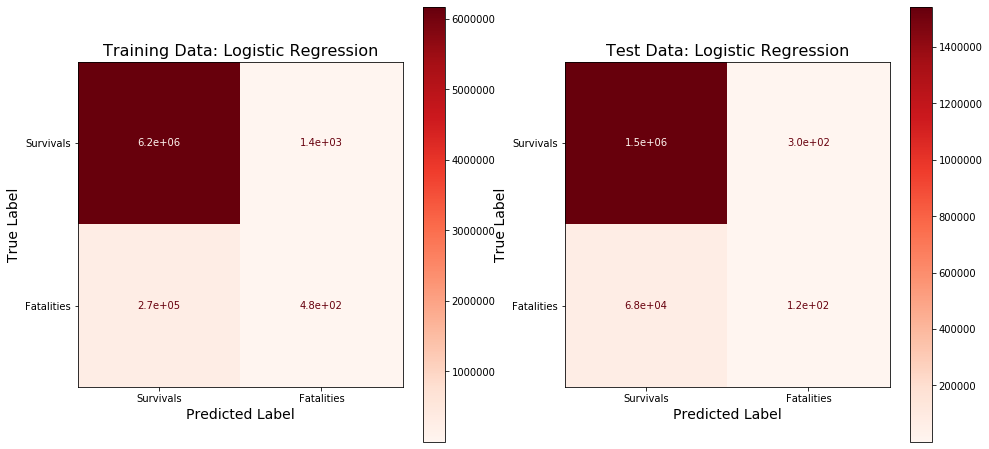

In [24]:
# Normalized confusion matrix plot for training and test data
y_class_names = ['Survivals','Fatalities']

fig3D1, (ax3D1a,ax3D1b) = plt.subplots(1,2,figsize=(16,8))

# Training Data: Logistic Regression
disp = plot_confusion_matrix(clf_lr,X_train,y_train,#normalize='all',
                             ax=ax3D1a,display_labels=y_class_names,cmap='Reds')
ax3D1a.set_title('Training Data: Logistic Regression',size=16)
ax3D1a.set_xlabel('Predicted Label',size=14)
ax3D1a.set_ylabel('True Label',size=14)

# Test Data: Logistic Regression
disp = plot_confusion_matrix(clf_lr,X_test,y_test,#normalize='all',
                             ax=ax3D1b,display_labels=y_class_names,cmap='Reds')
ax3D1b.set_title('Test Data: Logistic Regression',size=16)
ax3D1b.set_xlabel('Predicted Label',size=14)
ax3D1b.set_ylabel('True Label',size=14)

#plt.savefig('../graphics/CP1-04a_fig03D1.png') # Export confusion matrix plot to PNG file
plt.show()

It may seem that the baseline Logistic Regression model performs well given the classification reports for both the training and test data are similar, however, this is not the case. The two classes of the target variable (`fatality`) are heavily imbalanced. The classification accuracy for both the training and test sets can be attributed to the fact that the model accurately predicts the <em>majority</em> class (<strong>Survivals</strong>) given its high frequency in the original dataset. 

<p>This notion is supported by the fact that the null accuracy is nearly the same as the classification accuracy for both the training and test sets. In addition, the recall scores clearly show that the classifier fails to detect observations within the <em>minority</em> class (<strong>Fatalities</strong>) yet always detects those within the <em>majority</em> class.</p>

In [25]:
# Make predictions with Random Forest classifier
ypred_test_rf = clf_rf.predict(X_test)

# Evaluation metrics for Random Forest classifier
print('CLASSIFIER: RANDOM FOREST (TEST DATA)')
print()
print(f'Classification Accuracy: {accuracy_score(y_test, ypred_test_rf):.4f} (y_test, ypred_test_rf)')
print(f'Null Accuracy:           {null_accuracy(y_test):.4f} (y_test)')
print(f'Recall Score:            {recall_score(y_test, ypred_test_rf):.4f} (y_test, ypred_test_rf)')
print()
print('Classification Report:')
print(classification_report(y_test, ypred_test_rf))

CLASSIFIER: RANDOM FOREST (TEST DATA)

Classification Accuracy: 0.9573 (y_test, ypred_test_rf)
Null Accuracy:           0.9577 (y_test)
Recall Score:            0.0248 (y_test, ypred_test_rf)

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98   1542813
        True       0.42      0.02      0.05     68087

    accuracy                           0.96   1610900
   macro avg       0.69      0.51      0.51   1610900
weighted avg       0.94      0.96      0.94   1610900



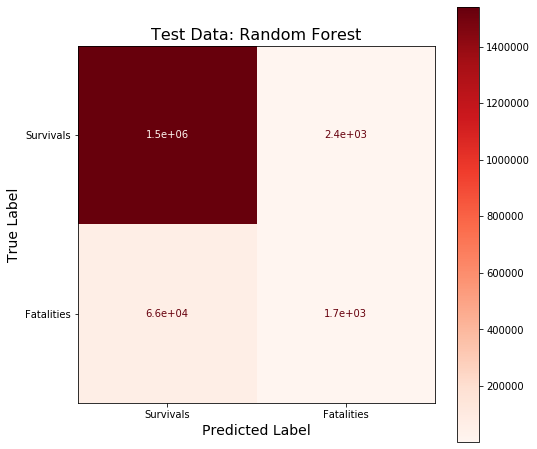

In [26]:
# Normalized confusion matrix plot for test data
y_class_names = ['Survivals','Fatalities']
fig3D2, ax3D2 = plt.subplots(figsize=(8,8))

# Test Data: Random Forest
disp = plot_confusion_matrix(clf_rf,X_test,y_test,#normalize='all',
                             ax=ax3D2,display_labels=y_class_names,cmap='Reds')
ax3D2.set_title('Test Data: Random Forest',size=16)
ax3D2.set_xlabel('Predicted Label',size=14)
ax3D2.set_ylabel('True Label',size=14)

#plt.savefig('../graphics/CP1-04a_fig03D2.png') # Export confusion matrix plot to PNG file
plt.show()

The baseline Random Forest classifier offers marginal improvements in <strong>recall</strong> and <strong>precision</strong> for predicting fatalities (0.02 and 0.42, respectively) when compared to that of its Logistic Regression counterpart (0.00 and 0.28, respectively). However, both models severely under-perform with respect to the aforementioned metrics. For this reason, separate notebooks will be used to explore different sampling techniques that are tailored to improve classification on imbalanced datasets such as this one.<p><a href=#TOC>TOC</a></p>